In [21]:

import cv2
import os, glob

import numpy as np
import seaborn as sns
from imutils import paths
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet101, Xception
from tensorflow.keras.layers import Input, Dense, Flatten, AveragePooling2D, Dropout, BatchNormalization, Conv2D


In [16]:

LR = 0.001
EPOCHS = 15
BATCH_SIZE = 15
COVID_LEN = 75#len(glob.glob('./' + 'covid2' + '/*'))

NO_COVID_LEN = 75#len(glob.glob('./' + 'nocovid' + '/*'))
print(NO_COVID_LEN)
INP_SIZE = (224,224,3)


75


In [10]:

def create_data(dir_name):
    temp_data = []
    img_list = glob.glob('./' + dir_name + '/*')
    print(len(img_list))
    for img in img_list[:COVID_LEN]:    #
        image = cv2.imread(img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        temp_data.append(image)
    return temp_data

data = []
labels = []

covid_dir = 'covid2'
normal_dir = 'nocovid'


data.extend(create_data(covid_dir))
data.extend(create_data(normal_dir))


labels.extend([1] * COVID_LEN)
labels.extend([0]*1*NO_COVID_LEN)

data = np.array(data)/255.0
labels = np.array(labels)

print(data.shape)
print(labels.shape)

435
216
(150, 224, 224, 3)
(150,)


In [11]:

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

(x_train, x_test, y_train, y_test) = train_test_split(
    data,
    labels,
    test_size=0.20,
    stratify=labels,
    random_state=25
)
trainAug = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest"
)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(120, 224, 224, 3)
(120, 2)
(30, 224, 224, 3)
(30, 2)


In [26]:

def generate_custom_model():
    
    model = Sequential()
    model.add(BatchNormalization(input_shape=INP_SIZE))
    model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(AveragePooling2D(pool_size=(2,2)))
    model.add(Dropout(0.35))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.35))
    model.add(Dense(2, activation='softmax'))
    
    return model

def generate_pretrained_model(model_name):
    if model_name == 'VGG16':
        model = VGG16(
            include_top = False,
            weights = 'imagenet',
            input_tensor = Input(shape=INP_SIZE)
        )
    elif model_name == 'ResNet101':
        model = ResNet101(
            include_top = False,
            weights = 'imagenet',
            input_tensor = Input(shape=INP_SIZE)
        )
    elif model_name == 'Xception':
        model = Xception(
            include_top = False,
            weights = 'imagenet',
            input_tensor = Input(shape=INP_SIZE)
        )
    else:
        model = None
        print('Invalid Choice!')
    
    return model


def fit_model(model, model_name):
    optim = Adam(lr = LR, decay = LR/EPOCHS)
    
    if model_name == 'Custom':
        model.compile(loss="categorical_crossentropy", optimizer=optim, metrics=["accuracy"])
        history = model.fit_generator(
            trainAug.flow(x_train, y_train, batch_size = BATCH_SIZE),
            steps_per_epoch = len(x_train) // BATCH_SIZE,
            validation_data = (x_test, y_test),
            validation_steps = len(x_test) // BATCH_SIZE,
            epochs = EPOCHS
        )
    else :
        for layer in model.layers:
            layer.trainable = False
        # top layer for shaping output    
        headModel = model.output
        headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
        headModel = Flatten(name="flatten")(headModel)
        headModel = Dense(64, activation="relu")(headModel)
        headModel = Dropout(0.5)(headModel)
        headModel = Dense(2, activation="softmax")(headModel)
        model = Model(inputs=model.input, outputs=headModel)
        model.compile(loss="categorical_crossentropy", optimizer=optim, metrics=["accuracy"])
        
        history = model.fit_generator(
            trainAug.flow(x_train, y_train, batch_size = BATCH_SIZE),
            steps_per_epoch = len(x_train) // BATCH_SIZE,
            validation_data = (x_test, y_test),
            validation_steps = len(x_test) // BATCH_SIZE,
            epochs = EPOCHS
        )
    
    return history, model


def display_history(history_):
    fig, ax = plt.subplots(1,2, figsize=(12, 3))
    ax[0].plot(history_.history['loss'], color='b', label="training_loss")
    ax[0].plot(history_.history['val_loss'], color='r', label="validation_loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].plot(history_.history['accuracy'], color='b', label="training_accuracy")
    ax[1].plot(history_.history['val_accuracy'], color='r',label="validation_accuracy")
    legend = ax[1].legend(loc='best', shadow=True)

def plot_metrices(model_):
    
    plt.figure()
    ax = plt.subplot()
    ax.set_title('Confusion Matrix')
    
    pred = model_.predict(x_test, batch_size = BATCH_SIZE)
    pred = np.argmax(pred, axis = 1)
    
    cm = confusion_matrix(y_test.argmax(axis = 1), pred)
    classes=['normal', 'covid19']
    sns.heatmap(cm, annot = True, xticklabels = classes, yticklabels = classes, cmap = 'Reds')

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show
    
    print(classification_report(y_test.argmax(axis = 1), pred))
    total = sum(sum(cm))
    acc = (cm[0, 0] + cm[1, 1]) / total
    sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    
    print('Test roc_auc_score: ', roc_auc_score(y_test.argmax(axis = 1), pred))
    print("ACC: {:.4f}".format(acc))
    print("Sensitivity: {:.4f}".format(sensitivity))
    print("Specificity: {:.4f}".format(specificity))
    
    

In [13]:
   
custom_mod = generate_custom_model()
vgg_mod = generate_pretrained_model('VGG16')
resnet_mod = generate_pretrained_model('ResNet101')
xception_mod = generate_pretrained_model('Xception')    


Epoch 1/15
8/8 [==============================] - 69s 9s/step - loss: 0.7153 - accuracy: 0.6083 - val_loss: 0.6746 - val_accuracy: 0.5000
Epoch 2/15
8/8 [==============================] - 68s 8s/step - loss: 0.7871 - accuracy: 0.5417 - val_loss: 0.6321 - val_accuracy: 0.6333
Epoch 3/15
8/8 [==============================] - 68s 8s/step - loss: 0.7045 - accuracy: 0.5500 - val_loss: 0.6119 - val_accuracy: 0.7333
Epoch 4/15
8/8 [==============================] - 67s 8s/step - loss: 0.6549 - accuracy: 0.6000 - val_loss: 0.5933 - val_accuracy: 0.7333
Epoch 5/15
8/8 [==============================] - 68s 8s/step - loss: 0.6538 - accuracy: 0.6083 - val_loss: 0.5828 - val_accuracy: 0.7333
Epoch 6/15
8/8 [==============================] - 68s 8s/step - loss: 0.6372 - accuracy: 0.6583 - val_loss: 0.5703 - val_accuracy: 0.7667
Epoch 7/15
8/8 [==============================] - 67s 8s/step - loss: 0.6186 - accuracy: 0.6583 - val_loss: 0.5657 - val_accuracy: 0.7333
Epoch 8/15
8/8 [==================

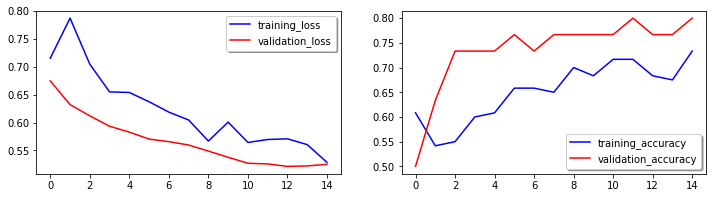

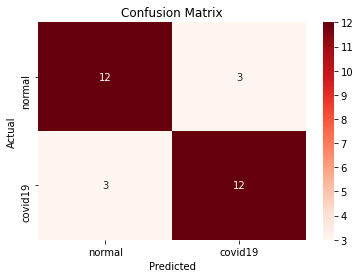

In [17]:
(vgg_his, vgg_mod)= fit_model(vgg_mod, 'VGG16')
display_history(vgg_his)
plot_metrices(vgg_mod)
vgg_mod.save('vgg.h5')

Epoch 1/15
8/8 [==============================] - 28s 3s/step - loss: 0.7628 - accuracy: 0.6167 - val_loss: 0.5050 - val_accuracy: 0.7000
Epoch 2/15
8/8 [==============================] - 27s 3s/step - loss: 0.5229 - accuracy: 0.7167 - val_loss: 0.4339 - val_accuracy: 0.7667
Epoch 3/15
8/8 [==============================] - 27s 3s/step - loss: 0.5436 - accuracy: 0.6833 - val_loss: 0.5051 - val_accuracy: 0.7667
Epoch 4/15
8/8 [==============================] - 27s 3s/step - loss: 0.5218 - accuracy: 0.7333 - val_loss: 0.4441 - val_accuracy: 0.7333
Epoch 5/15
8/8 [==============================] - 28s 3s/step - loss: 0.4975 - accuracy: 0.6917 - val_loss: 0.4544 - val_accuracy: 0.7667
Epoch 6/15
8/8 [==============================] - 27s 3s/step - loss: 0.4604 - accuracy: 0.7417 - val_loss: 0.4061 - val_accuracy: 0.7667
Epoch 7/15
8/8 [==============================] - 27s 3s/step - loss: 0.4324 - accuracy: 0.7750 - val_loss: 0.3897 - val_accuracy: 0.7667
Epoch 8/15
8/8 [==================

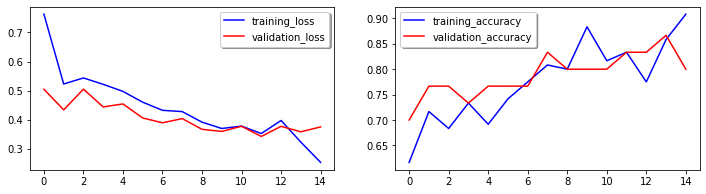

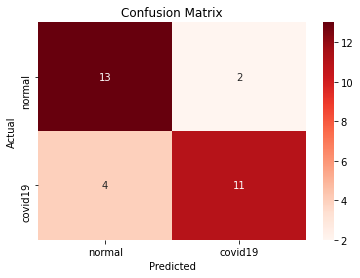

In [20]:
xcep_his, xception_mod = fit_model(xception_mod, 'Xception')
display_history(xcep_his)
plot_metrices(xception_mod)
xception_mod.save('xception.h5')